In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "jpg" #jpg, notebook_connected
print(np.__version__)
print(pd.__version__)

1.18.1
1.0.3


***
## Info about the datafile

- The column names and 1 row of sample data is shown below. 
- DB: AS = Aerospike, SQL = MySQL. 
- Schema, Table, FKrepFactor, Constraints: Refer to the paper or presentation slides for the structure of Schemas 1-3

`DB, Schema, Operation, Table, NumRows, FKrepFactor, Constraints, mean, median, stdev, timestamp
AS, 1, Ins, Table1A, 100, 1, True, 1.0257577896118164, 0.9601116180419922, 0.23162600665160718, 2020-03-31_224308`

In [2]:
benchDF = pd.read_csv('../data/NoSQLvsSQL_bench_data.csv', 
             names = ["DB", "Schema", "Operation", "Table", "NumRows", "FKrepFactor", "Constraints", 
                        "mean", "median", "stdev", "timestamp"],
             dtype = {"DB":str, "Schema":int, "Operation":str, "Table":str, "NumRows":int, "FKrepFactor":int, 
                      "Constraints":str, "mean":float, "median":float, "stdev":float, "timestamp":str})

The next two lines of code, `.head()` and `.info()` simply help us get a feel for our data file.

In [3]:
benchDF.head()

,DB,Schema,Operation,Table,NumRows,FKrepFactor,Constraints,mean,median,stdev,timestamp
0,AS,1,Ins,Table1A,100,1,True,1.076329,0.960708,0.454601,2020-03-31_225032
1,AS,1,Ins,Table1B,100,1,True,2.159445,1.910329,0.752107,2020-03-31_225032
2,AS,1,Ins,Table1A,100,1,False,1.058707,0.966311,0.441816,2020-03-31_225033
3,AS,1,Ins,Table1B,100,1,False,1.057017,0.962973,0.493509,2020-03-31_225033
4,AS,1,Upd,Table1A,100,1,False,1.049988,0.950694,0.380215,2020-03-31_225033


In [4]:
benchDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DB           576 non-null    object 
 1   Schema       576 non-null    int32  
 2   Operation    576 non-null    object 
 3   Table        576 non-null    object 
 4   NumRows      576 non-null    int32  
 5   FKrepFactor  576 non-null    int32  
 6   Constraints  576 non-null    object 
 7   mean         576 non-null    float64
 8   median       576 non-null    float64
 9   stdev        576 non-null    float64
 10  timestamp    576 non-null    object 
dtypes: float64(3), int32(3), object(5)
memory usage: 42.9+ KB


***
To simplify other filter and query statements, we'll create 3 dataframes that contain pre-filtered data. One for MySQL data and one each for Aerospike data (with and without constraints enabled).

In [5]:
ASDFConstraintsYes = benchDF[(benchDF["DB"] == "AS") & (benchDF["Constraints"].str.contains("True"))]
ASDFConstraintsNo = benchDF[(benchDF["DB"] == "AS") & (benchDF["Constraints"].str.contains("False"))]
SQLDF = benchDF[benchDF["DB"] == "SQL"]

Verify the size of each resulting dataframe matches what we expect,

In [6]:
print("AeroSpike records WITH constraints:",ASDFConstraintsYes.shape)
print("AeroSpike records WITHOUT constraints:",ASDFConstraintsNo.shape)
print("MySQL records with constraints (implied):",SQLDF.shape)

AeroSpike records WITH constraints: (192, 11)
AeroSpike records WITHOUT constraints: (192, 11)
MySQL records with constraints (implied): (192, 11)


***
### Statistics for each of our 3 new dataframes. All times are in mS.

In [7]:
ASDFConstraintsYes[["mean", "median", "stdev"]].describe()

,mean,median,stdev
count,192.000000,192.000000,192.000000
mean,1.980379,1.824597,1.095172
std,1.264896,1.184507,1.121474
min,0.934662,0.913382,0.055409
25%,1.068206,0.994503,0.399630
50%,1.163059,1.036167,0.661322
75%,2.818940,2.668172,1.500443
max,6.437092,5.485892,7.298537


In [8]:
ASDFConstraintsNo[["mean", "median", "stdev"]].describe()

,mean,median,stdev
count,192.000000,192.000000,192.000000
mean,1.097234,0.995890,0.778472
std,0.090822,0.037505,0.814084
min,0.904312,0.895262,0.052312
25%,1.036867,0.970960,0.297875
50%,1.109152,0.998199,0.509287
75%,1.155150,1.020879,0.997779
max,1.456928,1.092672,6.555353


In [9]:
SQLDF[["mean", "median", "stdev"]].describe()

,mean,median,stdev
count,192.000000,192.000000,192.000000
mean,13.461341,13.405674,2.008613
std,19.041243,19.067328,2.650903
min,3.602700,3.602386,0.130901
25%,3.752977,3.711313,0.554544
50%,4.173023,4.123032,1.041048
75%,8.678021,8.576334,1.714058
max,66.482938,66.502094,9.709312


***
Here, we'll define some functions to simplify data extraction and plotting.

In [10]:
def getValues(DF, schema, op, table, FKrep, value):
    schemarepDF = DF.query('Schema==@schema and FKrepFactor==@FKrep')
    opMask = schemarepDF["Operation"].str.contains(op)
    tableMask = schemarepDF["Table"].str.contains(table)
    return schemarepDF[opMask & tableMask].sort_values(by=["NumRows"])[["NumRows", "mean"]]

In [11]:
testDF = getValues(ASDFConstraintsYes, 1, "Ins", "Table1B", 1, "mean")
testDF.head()

,NumRows,mean
1,100,2.159445
145,1000,2.124964
289,10000,2.250650
433,100000,2.548501


In [12]:
AS_Marker = go.scatter.Marker(symbol="circle", size=8)
SQL_Marker = go.scatter.Marker(symbol="square", size=8)
dashLine = go.scatter.Line(dash='dash')

In [13]:
def plot(schema, op, table, FKrep, titleBase):
    plotS1DF = getValues(ASDFConstraintsYes, schema, op, table, FKrep, "mean")
    plotS2DF = getValues(ASDFConstraintsNo, schema, op, table, FKrep, "mean")
    plotS3DF = getValues(SQLDF, schema, op, table, FKrep, "mean")
    fig = go.Figure()
    
    if op == "Ins": useInTitle = "Insert"
    if op == "Upd": useInTitle = "Update"
    if op == "Del": useInTitle = "Delete"
    fig.layout.title="Schema "+str(schema)+", "+table+", FK Repetition = "+str(FKrep)+", "+useInTitle+" "+titleBase
    fig.layout.xaxis.title="Number of records in Table"
    fig.layout.xaxis.type="log"
    fig.layout.yaxis.title="Time (mS)"

    fig.add_trace(go.Scatter(x=plotS1DF["NumRows"], y=plotS1DF["mean"], marker=AS_Marker, name="Aerospike, Constraints"))
    fig.add_trace(go.Scatter(x=plotS1DF["NumRows"], y=plotS2DF["mean"], marker=AS_Marker, line=dashLine, name="Aerospike, No Constraints"))
    fig.add_trace(go.Scatter(x=plotS1DF["NumRows"], y=plotS3DF["mean"], marker=SQL_Marker, name="MySQL"))
    fig.show()
    return

In [14]:
def plotFKreps(schema, op, table, titleBase):
    
    plotS1DF = getValues(ASDFConstraintsYes, schema, op, table, 1, "mean")
    plotS2DF = getValues(ASDFConstraintsYes, schema, op, table, 5, "mean")
    plotS3DF = getValues(ASDFConstraintsYes, schema, op, table, 10, "mean")
    plotS4DF = getValues(SQLDF, schema, op, table, 1, "mean")
    plotS5DF = getValues(SQLDF, schema, op, table, 5, "mean")
    plotS6DF = getValues(SQLDF, schema, op, table, 10, "mean")
    fig = go.Figure()
    
    if op == "Ins": useInTitle = "Insert"
    if op == "Upd": useInTitle = "Update"
    if op == "Del": useInTitle = "Delete"
    fig.layout.title="Schema "+str(schema)+", "+table+", "+useInTitle+" "+titleBase
    fig.layout.xaxis.title="Number of records in Table"
    fig.layout.xaxis.type="log"
    fig.layout.yaxis.title="Time (mS)"

    fig.add_trace(go.Scatter(x=plotS1DF["NumRows"], y=plotS1DF["mean"], marker=AS_Marker, mode='lines+markers', name="Aerospike, FKrep = 1"))
    fig.add_trace(go.Scatter(x=plotS2DF["NumRows"], y=plotS2DF["mean"], marker=AS_Marker, mode='lines+markers', name="Aerospike, FKrep = 5"))
    fig.add_trace(go.Scatter(x=plotS3DF["NumRows"], y=plotS3DF["mean"], marker=AS_Marker, mode='lines+markers', name="Aerospike, FKrep = 10"))
    fig.add_trace(go.Scatter(x=plotS4DF["NumRows"], y=plotS4DF["mean"], marker=SQL_Marker, mode='lines+markers', name="MySQL, FKrep = 1"))
    fig.add_trace(go.Scatter(x=plotS5DF["NumRows"], y=plotS5DF["mean"], marker=SQL_Marker, mode='lines+markers', name="MySQL, FKrep = 5"))
    fig.add_trace(go.Scatter(x=plotS6DF["NumRows"], y=plotS6DF["mean"], marker=SQL_Marker, mode='lines+markers', name="MySQL, FKrep = 10"))
    fig.show()
    return

***
## Data plots

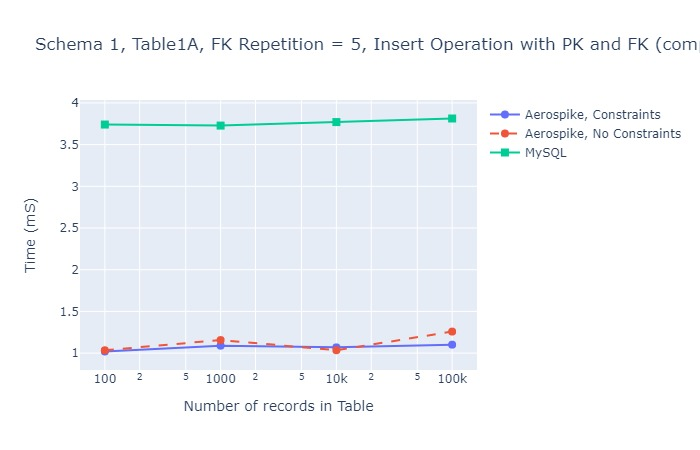

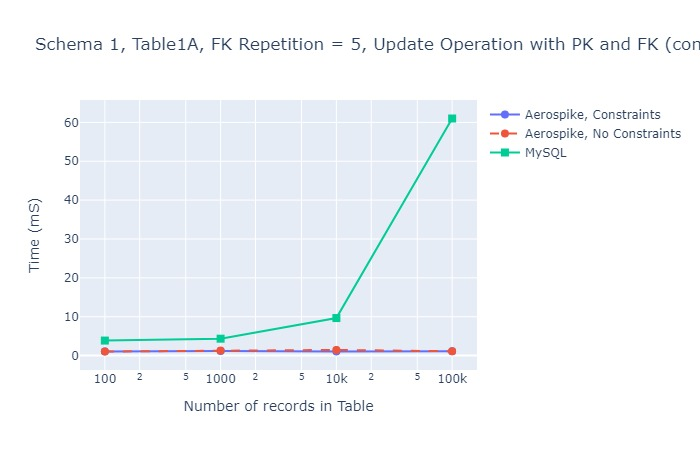

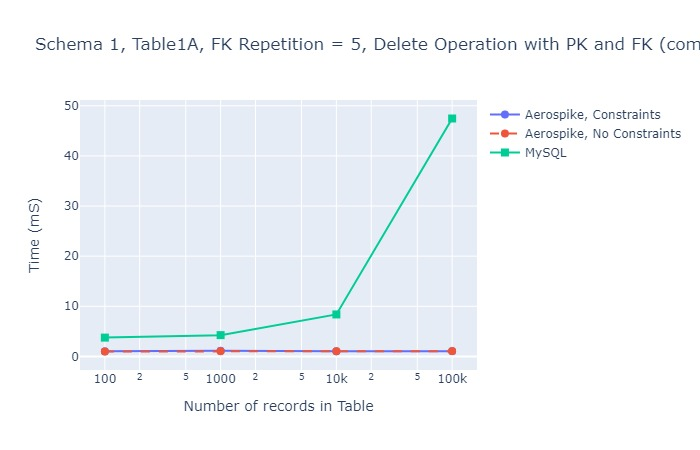

In [15]:
plot(1, "Ins", "Table1A", 5, "Operation with PK and FK (composite PK)")
plot(1, "Upd", "Table1A", 5, "Operation with PK and FK (composite PK)")
plot(1, "Del", "Table1A", 5, "Operation with PK and FK (composite PK)")

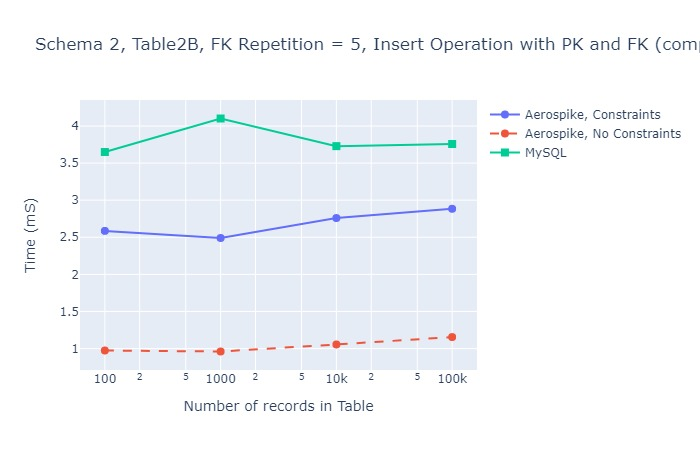

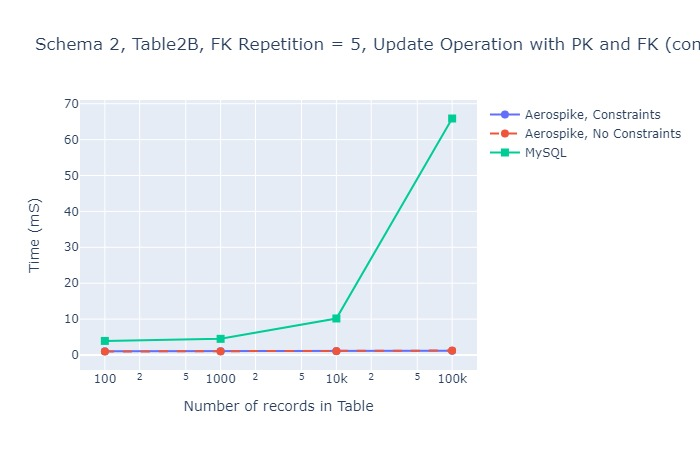

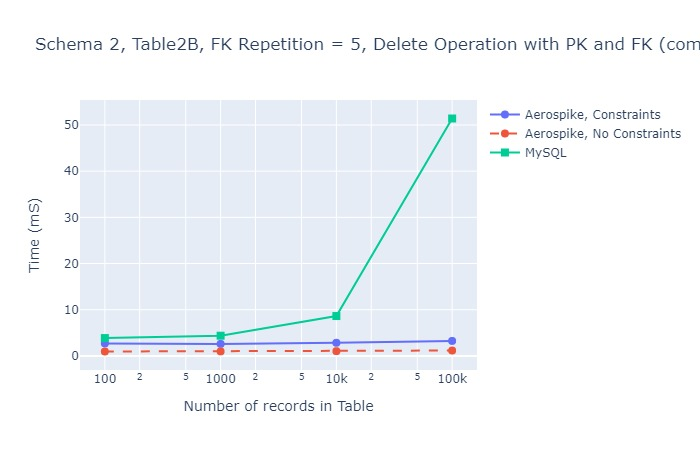

In [16]:
plot(2, "Ins", "Table2B", 5, "Operation with PK and FK (composite PK)")
plot(2, "Upd", "Table2B", 5, "Operation with PK and FK (composite PK)")
plot(2, "Del", "Table2B", 5, "Operation with PK and FK (composite PK)")

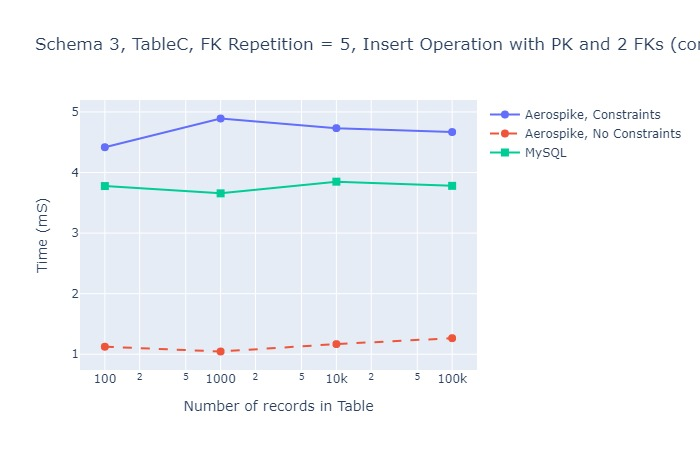

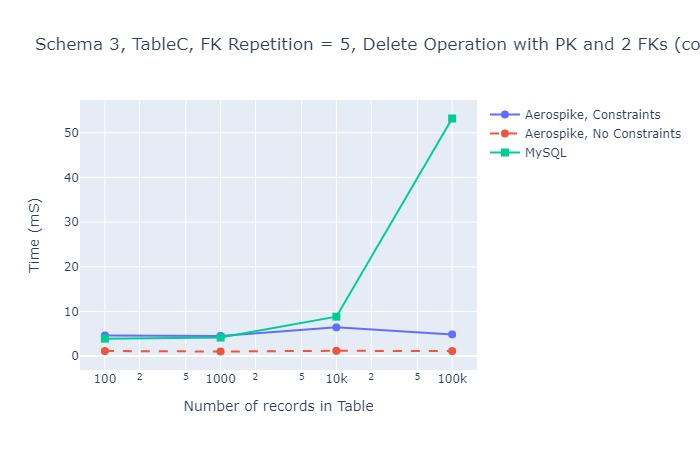

In [17]:
plot(3, "Ins", "TableC", 5, "Operation with PK and 2 FKs (composite PK)")
plot(3, "Del", "TableC", 5, "Operation with PK and 2 FKs (composite PK)")

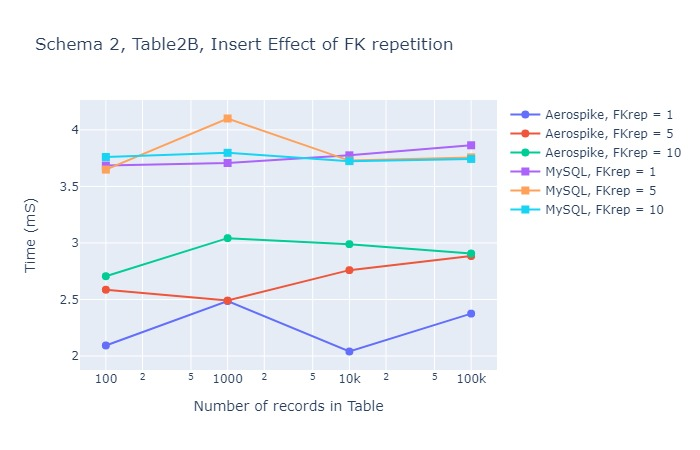

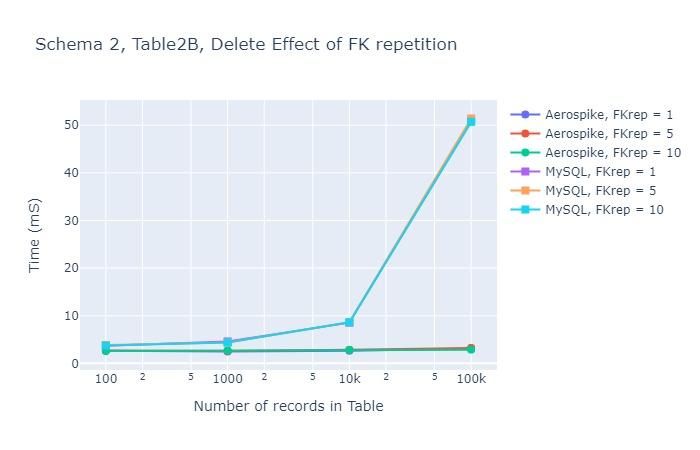

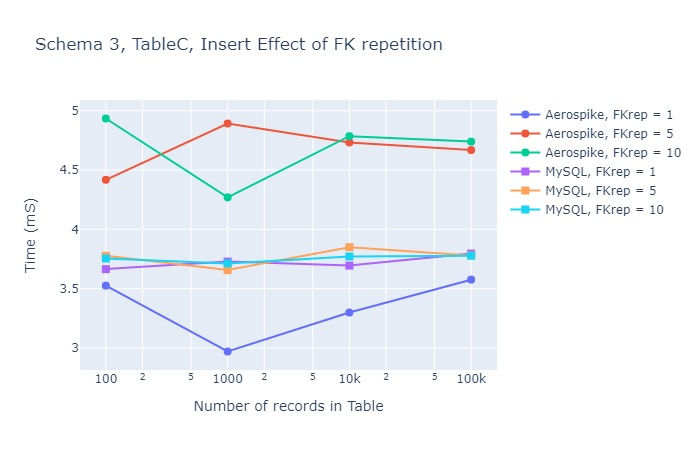

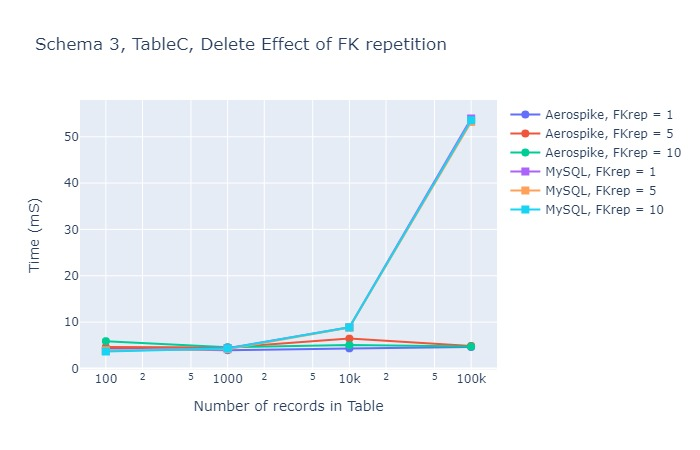

In [18]:
plotFKreps(2, "Ins", "Table2B", "Effect of FK repetition")
plotFKreps(2, "Del", "Table2B", "Effect of FK repetition")
plotFKreps(3, "Ins", "TableC", "Effect of FK repetition")
plotFKreps(3, "Del", "TableC", "Effect of FK repetition")